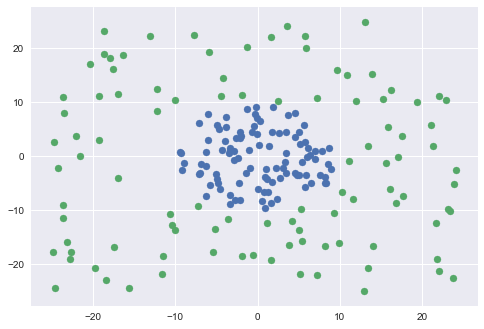

In [28]:
%matplotlib inline
import numpy as np
import os, string
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sns

center=np.mat([0.,0.])
#center2=np.mat([10.,10.])
#generate data
radius = 10.
num1=100
num2 = 100
np.random.seed(0)
data1 = np.ones([num1,3])
data2 = np.ones([num2,3])*-1.0
for i in range(0,num1):
    data1[i,:2] = 50. * (np.random.random([1,2])-0.5)
    while(np.linalg.norm(data1[i,:2]-center) > 10.0):
        data1[i,:2] = 50. * (np.random.random([1,2])-0.5)
for i in range(0,num2): 
    while(np.linalg.norm(data2[i,:2]-center) < 10.0):
        #print(data2[i,:])
        data2[i,:2] = 50. * (np.random.random([1,2])-0.5)
        
plt.scatter(x=data1[:,0],y=data1[:,1])
plt.scatter(x=data2[:,0],y=data2[:,1])
plt.show()

In [29]:
sigma = 0.5
x=np.mat(np.vstack((data1,data2)))
#print(np.tile(x[:,0].T,[x.shape[0],1]))
#print(np.tile(x[:,0],[1,x.shape[0]]))
kkx = np.square(np.tile(x[:,0].T,[x.shape[0],1])-np.tile(x[:,0],[1,x.shape[0]]))
#print(kkx)
kkx += np.square(np.tile(x[:,1].T,[x.shape[0],1])-np.tile(x[:,1],[1,x.shape[0]]))
kkx = np.sqrt(kkx)
kkx = np.exp(-sigma * kkx )
print(kkx)
print(kkx.shape)

[[  1.00000000e+00   5.85351395e-03   2.16484746e-02 ...,   6.25802763e-06
    2.10405708e-05   7.55640297e-04]
 [  5.85351395e-03   1.00000000e+00   1.87257618e-03 ...,   4.02476830e-04
    2.69646043e-05   2.79755522e-05]
 [  2.16484746e-02   1.87257618e-03   1.00000000e+00 ...,   7.81387344e-07
    8.12070712e-04   1.49242455e-02]
 ..., 
 [  6.25802763e-06   4.02476830e-04   7.81387344e-07 ...,   1.00000000e+00
    2.26142505e-08   1.17114098e-08]
 [  2.10405708e-05   2.69646043e-05   8.12070712e-04 ...,   2.26142505e-08
    1.00000000e+00   6.95821565e-04]
 [  7.55640297e-04   2.79755522e-05   1.49242455e-02 ...,   1.17114098e-08
    6.95821565e-04   1.00000000e+00]]
(200, 200)


In [36]:
lam = 1./2.
batch = x.shape[0]
with tf.device('/gpu:0'):
    alpha = tf.Variable(tf.random_uniform([batch,1],-1.0,1.0))
    alpha = tf.maximum(0.,alpha)
    KX = tf.placeholder("float", shape=[batch,batch])
    y = tf.placeholder("float", shape=[batch,1])
    loss = lam*tf.reduce_sum(tf.matmul(alpha,tf.transpose(alpha))*KX)
    tmp = tf.matmul(KX, alpha)
    tmp = y*tmp
    tmp = 1. - tmp
    tmp = tf.maximum(0.,tmp)
    tmp = 1./batch*tf.reduce_sum(tmp)
    loss += tmp
    optimizer = tf.train.GradientDescentOptimizer(0.0002)
    train_op = optimizer.minimize(loss)
    predict_op = tf.reduce_sum(tf.reduce_sum(tf.abs(alpha*y*KX),1) - y)

In [37]:
import sys,time
# test1 = tf.Variable([[1,2,3,4]])
# test2 = tf.tile(test1,[4,1])
# test3 = tf.tile(tf.reshape(test1,[4,1]),[1,4])
# test4=test2*test3-5
# test5=tf.maximum(0,test4)
# sess = tf.Session()
# init = tf.global_variables_initializer()
# sess.run(init)
# print(sess.run(test2))
# print(sess.run(test3))
# print(sess.run(test4))
# print(sess.run(test5))
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
for i in range(8000):
    #sys.stdout.write('\r epoch : %d' % i)
    #sys.stdout.flush()
    #time.sleep(0.2)
    _,pre = sess.run([train_op,predict_op], feed_dict={KX: kkx, y: x[:,2]})
    if i % 500 == 0:
        print(i,'loss:',pre)
    
resA = sess.run(alpha)
#print(resA)
#w=kkx

0 loss: 43611.8
500 loss: 31590.2
1000 loss: 24215.3
1500 loss: 18974.8
2000 loss: 15200.3
2500 loss: 12453.9
3000 loss: 10361.1
3500 loss: 8699.24
4000 loss: 7372.33
4500 loss: 6322.6
5000 loss: 5468.26
5500 loss: 4755.6
6000 loss: 4165.37
6500 loss: 3665.06
7000 loss: 3240.18
7500 loss: 2874.17


F:\Anaconda3\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


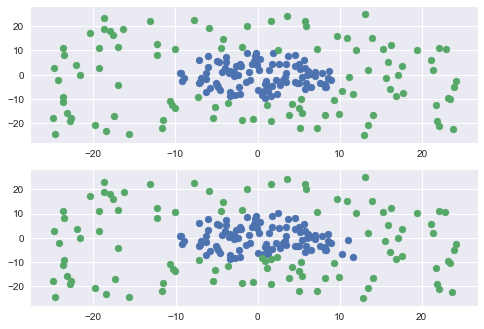

In [38]:
#print(resA.shape,kkx.shape,x[:,2].shape)
predict=np.multiply(resA,x[:,2])
#print(predict.shape)
predict=np.sum(np.multiply(predict,kkx),axis=0)
predict = predict.T
#print(predict)
#print(predict.shape)
#duibi = np.zeros((100,2))
#print(duibi.shape)
#duibi[:,0] = np.mat(predict.T>0.0).T
#duibi[:,1] = x[:,2].T>0
#print(duibi)
#print(predict>0.0)
#print(predict.shape)
predict=np.tile(predict,[1,3])
#print(predict>0.0)
ax = np.array(x)
predictSet1=ax[predict>0.0].reshape([-1,3])
predictSet2=ax[predict<0.0].reshape([-1,3])

#print(predictSet1)
fig = plt.figure()
ax = fig.add_subplot(211)
ax.scatter(x=data1[:,0],y=data1[:,1])
ax.scatter(x=data2[:,0],y=data2[:,1])
ax = fig.add_subplot(212)
ax.scatter(x=predictSet1[:,0],y=predictSet1[:,1])
ax.scatter(x=predictSet2[:,0],y=predictSet2[:,1])
fig.show()
#print(x)

In [35]:
print(resA)

[[  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  5.78314178e-02]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  2.36596842e-03]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  1.07724458e-01]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  8.23233351e-02]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  2.28622332e-02]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  5.63268661e-02]
 [  0.00000000e+00]
 [  0.00000000e+00]
